In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

# Part I: Probabilistic and Statistical Models for Outlier Detection

## Univariate extreme-value analysis

### Markov inequality

Tail inequalities can be used in order to bound the probability that a value in the tail of a probability distribution should be considered anomalous.

The strength of a tail inequality depends on the number of assumptions made about the underlying random variable.

Fewer assumptions lead to weaker inequalities but such inequalities apply to larger classes of random variables.

For example, the **Markov** and **Chebychev** inequalities are weak inequalities but they apply to very large classes of random variables.

On the other hand, the **Chernoff** bound and **Hoeffding** inequality are both stronger inequalities but they apply to restricted classes of random variables.

**Theorem**: Let X be a random variable that takes on only
non-negative random values. Then, for any constant $\alpha$ satisfying $E[X] < \alpha$, the following
is true: $$P(X > \alpha) \leq \frac{E[X]}{\alpha}$$

So for example you have some sample from a random variable that takes on only non-negative random values (say Log-normally distributed):

In [58]:
mean = 2
sigma = 0.7
sample = np.random.lognormal(mean=mean, sigma=sigma, size=10000)

In [59]:
count, bins, ignored = plt.hist(sample, 50, normed=1, facecolor='g', alpha=0.75)

[i.set_color("green") for i in plt.gca().get_xticklabels()]
[i.set_color("green") for i in plt.gca().get_yticklabels()]

x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mean)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.xlim((0, 140))

(0, 140)

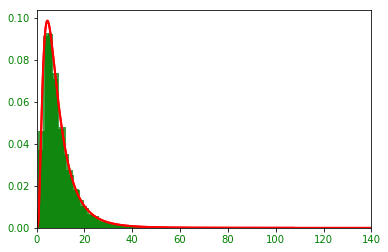

In [60]:
plt.show()

In [65]:
values, base = np.histogram(sample, normed=True, bins=50)
cumulative = np.cumsum(values)

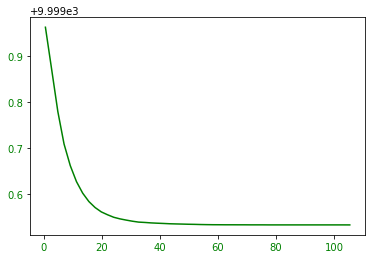

In [66]:
plt.plot(base[:-1], len(sample)-cumulative, c='green')
[i.set_color("green") for i in plt.gca().get_xticklabels()]
[i.set_color("green") for i in plt.gca().get_yticklabels()]
plt.show()

To be able to apply Markov inequality you need to know the true mean value.

In our case the true mean value is equal to 2.

All we need to do is to decide what number will be the threshold for outlier detection.

Suppose it is equal to 20.

Then according to Markov inequality $$P(X > 20) \leq \frac{1}{10}$$

Thus if we agreed that $\frac{1}{10}$ is appropriate borderline between inliers and outliers then we can use it to detect the last ones.

Pros:
- only one assumption sould be verified (non-negativity);
- only one true value should be known (mean);

Cons:
- it gives a threshold only for upper-tail;
- it doesn't give a [supremum](https://en.wikipedia.org/wiki/Infimum_and_supremum) for upper-tail boundary.

### Chebychev inequality

### t-Value Test

## Multivariate extreme-value analysis

### Mahalanobis Method

# Part II: Linear models for Outlier Detection

# Part III: Proximity-Based Outlier Detection